# Validation of `RIMEz` against `pyuvsim` reference simulations (first generation)

Lily Whitler, Steven Murray, and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

We compare point source visibilities simulated with `RIMEz` to a subset of the first generation of reference simulations produced by `pyuvsim`. Each reference simulation tests a different set of axes (e.g., times, frequencies, baselines, sources), so we use different reference simulations to characterize the behavior of `RIMEz` along each of these axes separately. For the source positioning simulation, 1.1, we use a uniform beam. For the reference simulations along the time and frequency axes, 1.2 and  1.3, we use four beams: uniform, Gaussian, Airy, and the HERA H1C dipole beam.

For all simulations along all axes, we find evidence of source positioning errors in `RIMEz`, even after transforming from ICRS to CIRS. Direct comparison of the source positions from `pyuvsim` (using `pyradiosky`) and those from `RIMEz` show discrepancies ranging from an arcsecond to several arcminutes.

### Imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
from datetime import datetime

import astropy.units as u
from astropy.io import fits
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation, AltAz, ICRS, CIRS, SkyCoord

from pyuvdata import UVData
import pyradiosky
from RIMEz import sky_models, beam_models, rime_funcs, management, utils

sys.path.append("../../")
import template_tools

### Description

In [3]:
print("Last executed: %s" %str(datetime.now()))

Last executed: 2020-06-29 14:37:29.678211


- **Major Step Description:** Compare every visibility simulator used in every other step to the formal `pyuvsim` reference simulations
- **Minor Variation Description:** Comparison of `RIMEz` visibilities with a subset of the first generation of `pyuvsim` reference simulations (1.1, 1.2, and 1.3)
- **Pipelines Tested:** `RIMEz` (point sources)
- **Criteria**:
  1. TBD

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. TBD

The visibilities simulated by `RIMEz` deviate in phase from the reference `pyuvsim` simulations, potentially indicating source position errors. Along the time axis, the discrepancies between the reference visibilities and `RIMEz` visibilities do not correlate with the location of the source in the sky. That is, the largest differences do not necessarily occur when a source is at zenith, near horizon, etc. Rather, they have a nearly periodic structure with time. Along the frequency axis, the `RIMEz` phase drifts away from the reference simulation phase with increasing frequency. Errors in source positioning are not apparent when imaged, however, direct calculation and comparison of the source positions from `RIMEz` and `pyuvsim` show errors on the order of an arcsecond to a few arcminutes.

We note that the parameter $\ell_\text{max}$, which depends on the frequency and baseline length, sets the spatial bandlimit in `RIMEz`. A too-small value of $\ell_\text{max}$ does not capture behavior at high frequencies (what constitutes "high" depends on the baseline length and frequency of interest).

### Software

`template_tools` is currently not working for `pyuvdata`, so I will do it manually below

In [4]:
template_tools.print_dep_versions(extras=['matplotlib', 'astropy', 'pyradiosky', 'RIMEz'],
                                  ignore=['pyuvdata', 'hera_stats', 'hera_sim', 'hera_qm', 'hera_pspec',
                                          'linsolve', 'uvtools', 'healvis', 'healpy'])

Module numpy      ....	Version 1.18.1 .......	Git None
Module h5py       ....	Version 2.10.0 .......	Git None
Module matplotlib ....	Version 3.1.3  .......	Git None
Module astropy    ....	Version 4.0.1.post1.......	Git None
Module pyradiosky ....	Version 0.0.2  .......	Git None
Module RIMEz      ....	Version 0.1.1.post0.dev42+g7f32129.......	Git None


`pyuvdata` : v2.0.2 (`c5a1b463f29b8164cda381e97e3d93a549be4179`)

### Utility Functions

In [5]:
def get_sorted_baselines(uvd, short_first=True):
    """
    Get baselines in a UVData object sorted by length
    
    Parameters
    ----------
    uvd : UVData
        UVData object containing the baselines to sort
    short_first : bool
        Whether to sort baselines by shortest to longest length, otherwise
        sort longest to shortest (default: True)
    
    Returns
    -------
    sorted_bls : array-like
        The sorted baselines
    """
    bls = np.unique(uvd.baseline_array)
    # sort the baselines by length, shortest to longest
    antpos, ants = uvd.get_ENU_antpos()
    ant_dict = dict(zip(ants, antpos))
    bl_length = []
    for bl in bls:
        ant1, ant2 = uvd.baseline_to_antnums(bl)
        bl_length.append(np.linalg.norm(ant_dict[ant1] - ant_dict[ant2]))
    inds = np.array(bl_length).argsort()
    sorted_bls = bls[inds]
    if not short_first:
        sorted_bls = sorted_bls[::-1]
    return sorted_bls

In [6]:
def get_xy_en_polarization(pol, x_orientation='e'):
    """
    Get a polarization string in both the X/Y and E/N conventions
    
    Parameters
    ----------
    pol : str
        The polarization for which to determine the X/Y and E/N strings
    x_orientation : str
        Which direction (east or north) corresponds to the x-orientation
    
    Returns
    -------
    xy_pol : str
        The polarization string in the X/Y convention
    en_pol : str
        The polarization string in the E/N convention corresponding to the X/Y string
    """
    pol, x_orientation = pol.lower(), x_orientation.lower()
    assert x_orientation in ['e', 'n'], 'X orientation must be either E or N'
    
    # sort out the y orientation
    if x_orientation == 'e':
        y_orientation = 'n'
    else:
        y_orientation = 'e'
        
    # determine the X/Y and E/N polarization strings
    if pol in ['xx', 'yy', 'xy', 'xx']:
        xy_pol = pol
        en_pol = xy_pol.replace('x', x_orientation).replace('y', y_orientation)
    elif pol in ['ee', 'nn', 'en', 'ne']:
        en_pol = pol
        xy_pol = en_pol.replace(x_orientation, 'x').replace(y_orientation, 'y')
    else:
        raise AssertionError('Polarization not recognized')
        
    return xy_pol, en_pol

In [7]:
def plot_comparison(ref_uvd, rimez_uvd, bls, xaxis, ax,
                    pol='ee', component='amp',
                    xlabel='', colors=None):
    """
    Make one-dimensional plots of pyuvsim and RIMEz visibilities
    """
    xy_pol, en_pol = get_xy_en_polarization(pol)    
    
    if component == 'real':
        function = np.real
        name = 'Real'
    elif component == 'imag':
        function = np.imag
        name = 'Imag'
    elif component == 'amp':
        function = np.abs
        name = 'Amp'
    elif component == 'phase':
        function = np.angle
        name = 'Phase'
    
    if colors is None:
        colors=['#5296C1', '#2F0F3E']
    
    ref_auto = ref_uvd.get_data((0, 0, 'xx'))
    for i, bl in enumerate(bls):
        ant1, ant2 = ref_uvd.baseline_to_antnums(bl)
        key_ref = (ant1, ant2, xy_pol)
        key_rimez = (ant1, ant2, en_pol)
        ref_data_all = ref_uvd.get_data(key_ref)
        rimez_data_all = rimez_uvd.get_data(key_rimez)
        
        # Overplot the visibilities in the left column
        ref_data = function(ref_data_all)
        rimez_data = function(rimez_data_all)
        if 'freq' in xlabel.lower():
            # The first time
            ref_data, rimez_data = ref_data[0], rimez_data[0]
        ax[i, 0].plot(xaxis, ref_data, c=colors[0], label='reference')
        ax[i, 0].plot(xaxis, rimez_data, c=colors[1], alpha=0.95, label='RIMEz')
        
        # And the difference of the function (amp, phase, real, imag) in the right column
        function_of_diff = function(rimez_data_all - ref_data_all)
        diff_of_function = function(rimez_data_all) - function(ref_data_all)
        if 'freq' in xlabel.lower():
            # The first time
            diff_of_function, function_of_diff = diff_of_function[0], function_of_diff[0]
        ax[i, 1].axhline(0, c='#6B6B6B', ls=':', lw=1.5)
        ax[i, 1].plot(xaxis, diff_of_function, c='#39B976',
                      label='{}(RIMEz) - {}(reference)'.format(name, name))
        ncols = 1
        
        # Also plot the amplitude of the difference (phase of the difference doesn't
        # make much sense, and the real and imaginary differences are the same thing)
        if component == 'amp':
            ax[i, 1].plot(xaxis, function_of_diff, c='#3C4D8A',
                          label='{}(RIMEz - reference)'.format(name))
            ncols = 2
        
        # Labeling things
        ax[i, 0].set_ylabel(name, fontsize=14)          
        ax[i, 1].text(1.03, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
                      va='center', rotation=270, transform=ax[i, 1].transAxes)
        
    ax[-1, 0].set_xlabel(xlabel, fontsize=14)
    ax[-1, 1].set_xlabel(xlabel, fontsize=14)
    ax[0, 0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25))
    ax[0, 1].legend(loc='center', ncol=ncols, columnspacing=1, handlelength=1.25,
                    fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25))

In [8]:
def plot_time_axis(ref_uvd, rimez_uvd, bls, ax,
                   pol='ee', component='amp',
                   colors=['#5296C1', '#2F0F3E'],
                   labels=['reference', 'RIMEz']):
    """
    Make one-dimensional plots of pyuvsim and RIMEz visibilities as a function of time
    """
    times = np.unique(ref_uvd.time_array)
    plot_comparison(ref_uvd, rimez_uvd, bls, times, ax=ax,
                    pol=pol, component=component,
                    xlabel='Time  [JD]', colors=colors)
    
def plot_freq_axis(ref_uvd, rimez_uvd, bls, ax,
                   pol='ee', component='amp',
                   colors=['#5296C1', '#2F0F3E'],
                   labels=['reference', 'RIMEz']):
    """
    Make one-dimensional plots of pyuvsim and RIMEz visibilities as a function of frequency
    """
    freqs = np.unique(ref_uvd.freq_array) / 1e6  # MHz
    plot_comparison(ref_uvd, rimez_uvd, bls, freqs, ax=ax,
                    pol=pol, component=component,
                    xlabel='Frequency  [MHz]', colors=colors)

### Data

The following paths point to the configuration files used for both the `pyuvsim` and `RIMEz` simulations used in this notebook, but are never read here.

In [9]:
config_base = '/lustre/aoc/projects/hera/Validation/test-neg1.1.0/config_files'
config_dict = {'1.1_uniform': os.path.join(config_base, 'obsparam_ref_1.1_downsampled_mwa.yaml'),
               '1.2_uniform': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_uniform.yaml'),
               '1.2_gauss': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_gauss.yaml'),
               '1.2_airy': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_airy.yaml'),
               '1.2_uvbeam': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_uvbeam.yaml'),
               '1.3_uniform': os.path.join(config_base, 'obsparam_ref_1.3_uniform.yaml'),
               '1.3_gauss': os.path.join(config_base, 'obsparam_ref_1.3_gauss.yaml'),
               '1.3_airy': os.path.join(config_base, 'obsparam_ref_1.3_airy.yaml'),
               '1.3_uvbeam': os.path.join(config_base, 'obsparam_ref_1.3_uvbeam.yaml')}

for key in config_dict.keys():
    assert os.path.exists(config_dict[key])

The following paths reflect the exact locations of all data used in this test. The `RIMEz` data were created with the script `prepare_rimez_data.py`.

In [10]:
ref_path = '/lustre/aoc/projects/hera/Validation/test-neg1.1.0/ref_sims'
ref_path_dict = {'1.1_uniform': os.path.join(ref_path, 'ref_1.1_uniform_downsampled.uvh5'),
                 '1.2_uniform': os.path.join(ref_path, 'ref_1.2_zenith_1freq_uniform.uvh5'),
                 '1.2_gauss': os.path.join(ref_path, 'ref_1.2_zenith_1freq_gauss.uvh5'),
                 '1.2_airy': os.path.join(ref_path, 'ref_1.2_zenith_1freq_airy.uvh5'),
                 '1.2_uvbeam': os.path.join(ref_path, 'ref_1.2_zenith_1freq_uvbeam.uvh5'),
                 '1.3_uniform': os.path.join(ref_path, 'ref_1.3_uniform.uvh5'),
                 '1.3_gauss': os.path.join(ref_path, 'ref_1.3_gauss.uvh5'),
                 '1.3_airy': os.path.join(ref_path, 'ref_1.3_airy.uvh5'),
                 '1.3_uvbeam': os.path.join(ref_path, 'ref_1.3_uvbeam.uvh5')}

for key in ref_path_dict.keys():
    assert os.path.exists(ref_path_dict[key])


rimez_path = '/lustre/aoc/projects/hera/Validation/test-neg1.1.0/rimez_sims'
rimez_path_dict = {'1.1_uniform': os.path.join(rimez_path, 'rimez_1.1_uniform_lmax1768_relabeled.uvh5'),
                   '1.2_uniform': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax250.uvh5'),
                   '1.2_gauss': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_gauss_lmax250.uvh5'),
                   '1.2_airy': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_airy_lmax250.uvh5'),
                   '1.2_uvbeam': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uvbeam_lmax250.uvh5'),
                   '1.3_uniform': os.path.join(rimez_path, 'rimez_1.3_uniform_lmax472.uvh5'),
                   '1.3_gauss': os.path.join(rimez_path, 'rimez_1.3_gauss_lmax472.uvh5'),
                   '1.3_airy': os.path.join(rimez_path, 'rimez_1.3_airy_lmax472.uvh5'),
                   '1.3_uvbeam': os.path.join(rimez_path, 'rimez_1.3_uvbeam_lmax472.uvh5')}

for key in rimez_path_dict.keys():
    assert os.path.exists(rimez_path_dict[key])

## Reference simulation 1.1 (one time, 100 MHz)

This simulation uses the layout of the MWA without the core to simulate 43 point sources that spell out the word "HERA" at 100 MHz for one time. However, `RIMEz` is unable to efficiently simulate the longest baselines in the MWA, so for this comparison, we restrict the baselines to the maximum baseline length of HERA, including outriggers, of 876 m. We then compare the images from `pyuvsim` and `RIMEz`.

We downselected the MWA with the script `downselect_mwa.py` and relabeled the antennas to  match the reference simulation antenna labels with `relabel_antennas.py`.

### 1.1: Array layout

Telescope RIMEz is not in known_telescopes.


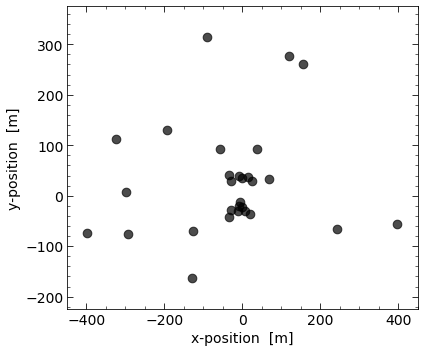

In [11]:
uvd_rimez_11 = {'uniform': UVData()}
uvd_rimez_11['uniform'].read(rimez_path_dict['1.1_uniform'])

antpos, ants = uvd_rimez_11['uniform'].get_ENU_antpos()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i in range(len(ants)):
    ax.scatter(antpos[i, 0], antpos[i, 1], c='k', marker='o', s=75, alpha=0.7)
ax.set_xlabel('x-position  [m]', fontsize=14)
ax.set_ylabel('y-position  [m]', fontsize=14)
ax.set_xlim([-450, 450])
ax.set_ylim([-225, 375])
fig.tight_layout()

**Figure 1** | The array layout for reference simulation 1.1 (the MWA without the core restricted to HERA baseline lengths).

### 1.1: Uniform beam

Images were created with CASA using the following script: `make_dirty_image.py`

Imaging parameters were as follows:
* `imsize = 2048`
* `cell = "1arcmin"`
* `weighting = "natural"`

In [12]:
image_path = '/lustre/aoc/projects/hera/Validation/test-neg1.1.0/imaging'
ref_11_image_path = os.path.join(image_path, 'ref_1.1_uniform_downsampled.image.fits')
rimez_11_image_path = os.path.join(image_path, 'rimez_1.1_uniform_lmax1768_relabeled.image.fits')
ref_11_image = fits.getdata(ref_11_image_path, ext=0)[0, 0]
rimez_11_image = fits.getdata(rimez_11_image_path, ext=0)[0, 0]

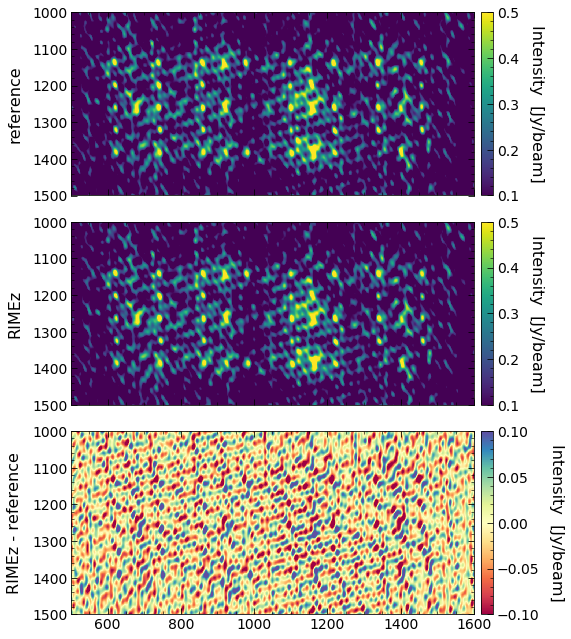

In [13]:
images = [ref_11_image, rimez_11_image, rimez_11_image - ref_11_image]
labels = ['reference', 'RIMEz', 'RIMEz - reference']
vlims = [(0.1, 0.5), (0.1, 0.5), (-0.1, 0.1)]
cmaps = ['viridis', 'viridis', 'Spectral']

fig, ax = plt.subplots(3, 1, sharex='col', figsize=(8, 9))
for i, axis in enumerate(ax):
    image = images[i]
    vmin, vmax, cmap = vlims[i][0], vlims[i][1], cmaps[i]
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    im = axis.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Intensity  [Jy/beam]', rotation=270, labelpad=25, fontsize=16)
    axis.set_ylabel(labels[i], labelpad=10, fontsize=16)
    axis.set_xlim([500, 1600])
    axis.set_ylim([1500, 1000])
fig.tight_layout()

**Figure 2** | CASA images of the reference simulation (top), `RIMEz` (middle), and the difference between the two (bottom). There are no obviously position errors, although the residuals are not quite noise-like. However, we later explicitly examine the source positions used by `RIMEz` and compare to the source positions used by `pyuvsim` and find differences ranging from a few arcseconds to a few arcminutes, while the angular resolution of this simulation at 100 MHz is ~15', so we do not expect to see these errors in the images.

## Reference simulation 1.2 (24 hours, 100 MHz)

This simulation has two point sources that rise, set, and transit zenith at different times, and is designed to test that sources move appropriately. We compare the amplitude and phase of the visibilities simulated by `RIMEz` and `pyuvsim` for a uniform, Gaussian, Airy, and HERA beam as a function of time. In all cases, we find evidence of phase errors from `RIMEz`, which are likely due to source position errors.

In [14]:
uvd_ref_12 = {'uniform': UVData(),
              'gauss': UVData(),
              'airy': UVData(),
              'hera': UVData()}
uvd_ref_12['uniform'].read(ref_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_ref_12['gauss'].read(ref_path_dict['1.2_gauss'], run_check_acceptability=False)
uvd_ref_12['airy'].read(ref_path_dict['1.2_airy'], run_check_acceptability=False)
uvd_ref_12['hera'].read(ref_path_dict['1.2_uvbeam'], run_check_acceptability=False)

uvd_rimez_12 = {'uniform': UVData(),
                'gauss': UVData(),
                'airy': UVData(),
                'hera': UVData()}
uvd_rimez_12['uniform'].read(rimez_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_rimez_12['gauss'].read(rimez_path_dict['1.2_gauss'], run_check_acceptability=False)
uvd_rimez_12['airy'].read(rimez_path_dict['1.2_airy'], run_check_acceptability=False)
uvd_rimez_12['hera'].read(rimez_path_dict['1.2_uvbeam'], run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
for beam in uvd_rimez_12.keys():
    uvd_rimez_12[beam].conjugate_bls(convention='ant2<ant1')

bls_12 = get_sorted_baselines(uvd_rimez_12['uniform'])

Telescope BLLITE is not in known_telescopes.
antenna_diameters is not set. Using known values for HERA.


### 1.2/1.3: Array layout

Reference simulations 1.2 and 1.3 both use the same array layout, a triangle composed of four antennas.

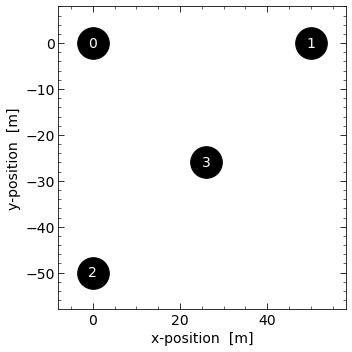

In [15]:
antpos, ants = uvd_ref_12['uniform'].get_ENU_antpos()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(ants)):
    ax.scatter(antpos[i, 0], antpos[i, 1], c='k', marker='o', s=1000)
    ax.text(antpos[i, 0], antpos[i, 1], str(i), color='w',
            ha='center', va='center', fontsize=14)
ax.set_xlabel('x-position  [m]', fontsize=14)
ax.set_ylabel('y-position  [m]', fontsize=14)
ax.set_xlim([-8, 58])
ax.set_ylim([-58, 8])
fig.tight_layout()

**Figure 3** | The array layout for reference simulations 1.2 and 1.3.

### 1.2: Uniform beam

#### Amplitude

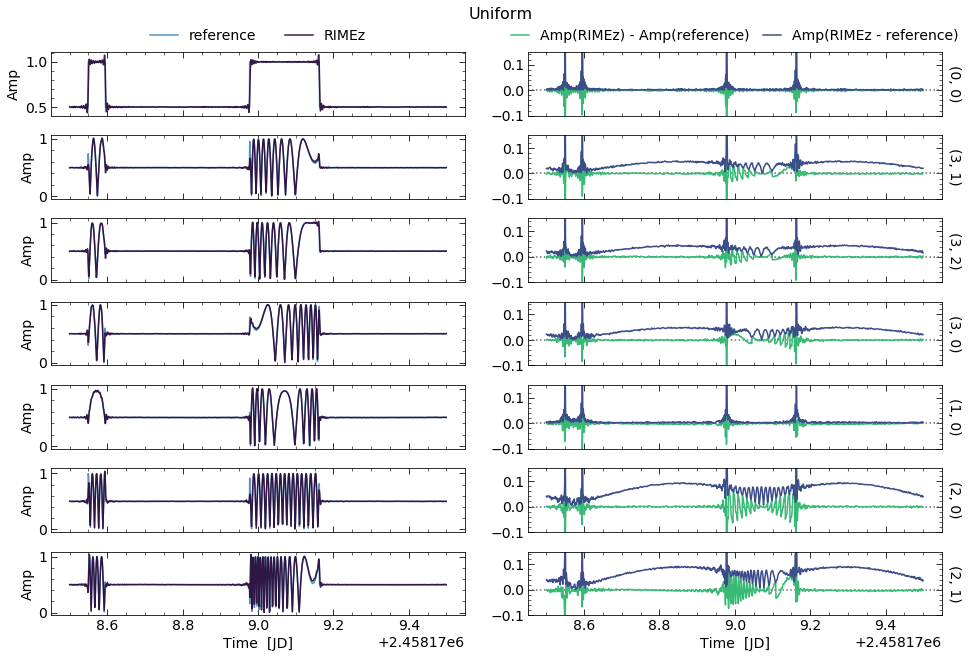

In [16]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['uniform'], uvd_rimez_12['uniform'], bls_12, ax=ax, component='amp')
for axis in ax[:, 1]:
    axis.set_ylim([-0.1, 0.15])
fig.suptitle('Uniform', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 4** | A comparison of the amplitudes of the simulated visibilities from `pyuvsim` and `RIMEz` for two sources transiting zenith with a uniform beam. Baselines are labeled on the right hand side. Left: The visibilities from `pyuvsim` (light blue) and `RIMEz` (dark blue) overplotted on top of each other. Right: The difference of the amplitudes (green) and the amplitude of the difference (blue). The difference of the amplitudes is near zero, except when the two sources are both above the horizon. The amplitude of the difference, however, drifts with time, indicating phase errors, since the differences of the amplitudes are near zero. The ringing in the differences when the two sources are both above horizon also likely also indicates position errors.

#### Phase

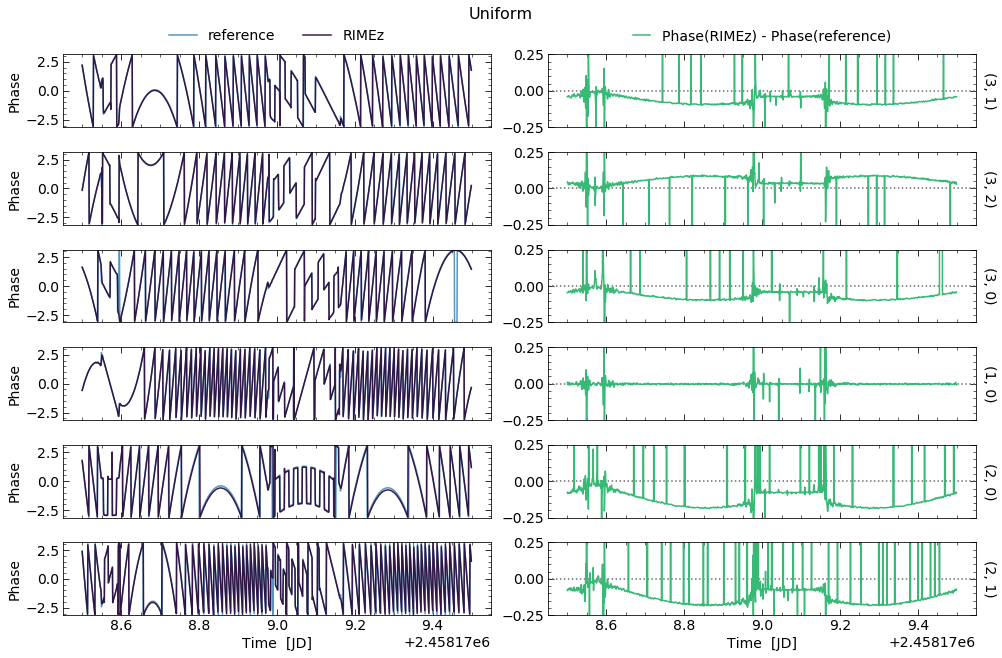

In [17]:
fig, ax = plt.subplots(len(bls_12)-1, 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['uniform'], uvd_rimez_12['uniform'], bls_12[1:], ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.suptitle('Uniform', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 5** | A comparison of the phases of the simulated visibilities from `pyuvsim` and `RIMEz` for two sources transiting zenith and a uniform beam. Left: The visibilities from `pyuvsim` (light blue) and `RIMEz` (dark blue) overplotted on top of each other. Right: The difference of the phases. The difference is nearly periodic with time with slight variations depending on the north-south component of the baseline (see the array layout in Figure 2).

### 1.2: Gaussian beam

#### Amplitude

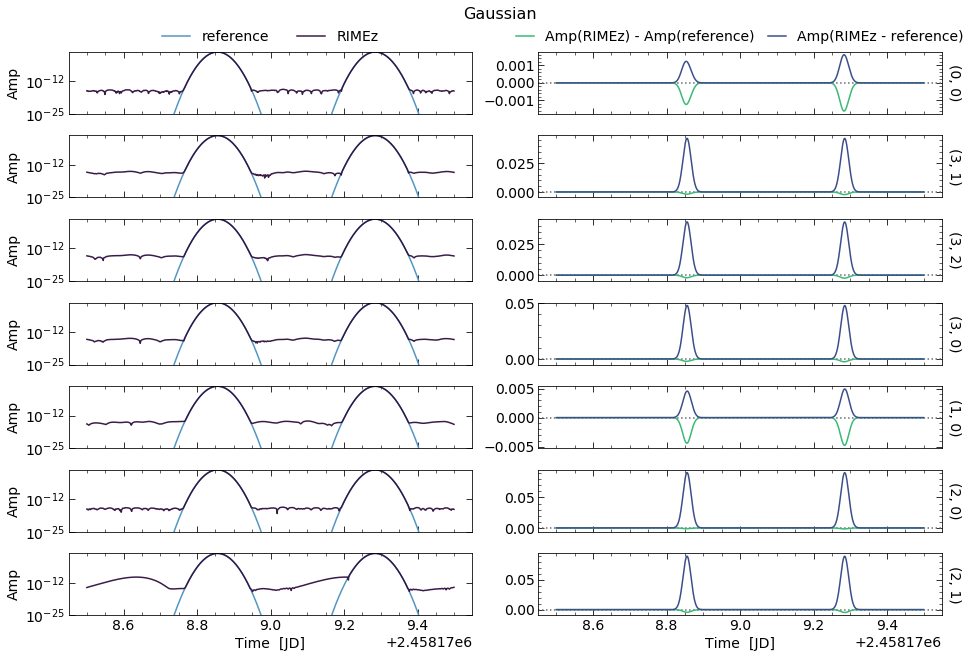

In [18]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['gauss'], uvd_rimez_12['gauss'], bls_12, ax=ax, component='amp')
for axis in ax[:, 0]:
    axis.set_ylim(ymin=1e-25)
    axis.set_yscale('log')
fig.suptitle('Gaussian', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 6** | The same as Figure 4 for a Gaussian beam. When the sources are near zenith, the `RIMEz` and `pyuvsim` visibilities agree. Away from zenith, the `RIMEz` visibilities floor at around $10^{-16} - 10^{-18}$ while the `pyuvsim` visibilities continue to orders of magnitude less ($10^{-132}$). This simply indicates that the dynamic range of `RIMEz` is much smaller than that of `pyuvsim`; `pyuvsim` performs a single calculation per source while `RIMEz` performs an FFT, limiting its result to around machine precision.

#### Phase

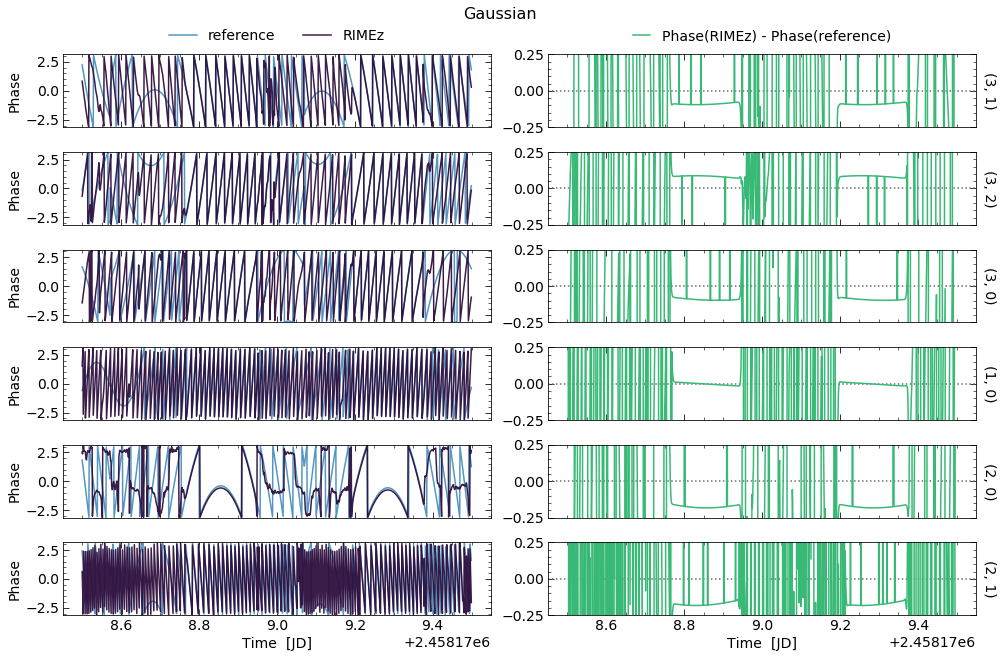

In [19]:
fig, ax = plt.subplots(len(bls_12)-1, 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['gauss'], uvd_rimez_12['gauss'], bls_12[1:], ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.suptitle('Gaussian', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 7** | The same as Figure 5 for a Gaussian beam. When the sources are away from zenith, `RIMEz` is dominated by numerical noise. When the sources are near zenith, the `RIMEz` phases deviate from the `pyuvsim` phases with the same structure as seen with the uniform beam.

### 1.2: Airy beam

#### Amplitude

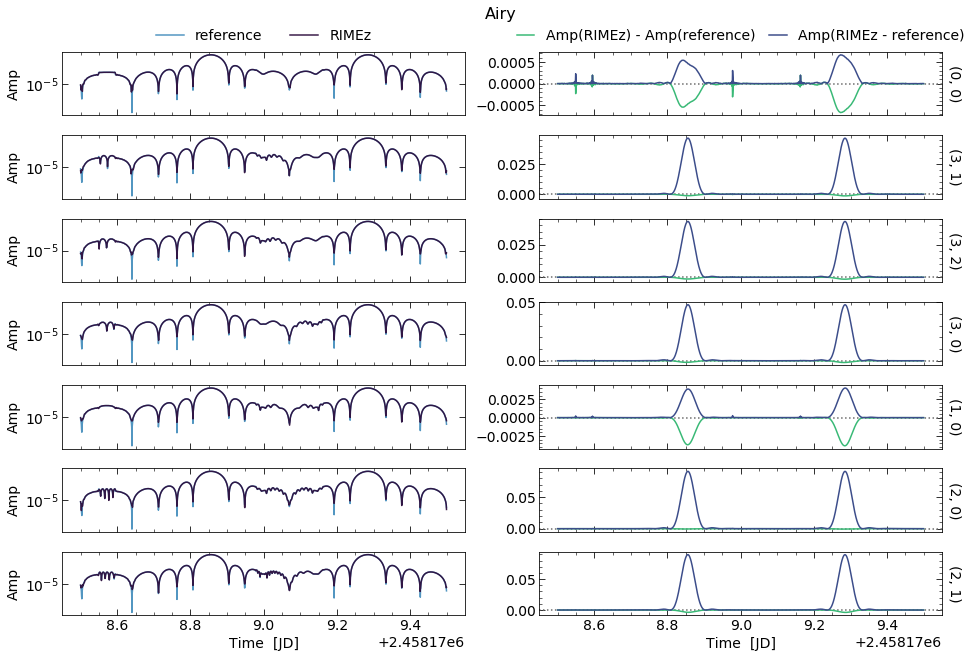

In [20]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['airy'], uvd_rimez_12['airy'], bls_12, ax=ax, component='amp')
for axis in ax[:, 0]:
    axis.set_yscale('log')
fig.suptitle('Airy', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 8** | The same as Figure 4 for an Airy beam. The `RIMEz` visibilities do not reach the smallest values of the `pyuvsim` visibilities, possibly due to the same dynamic range limitations as seen with the Gaussian beam.

#### Phase

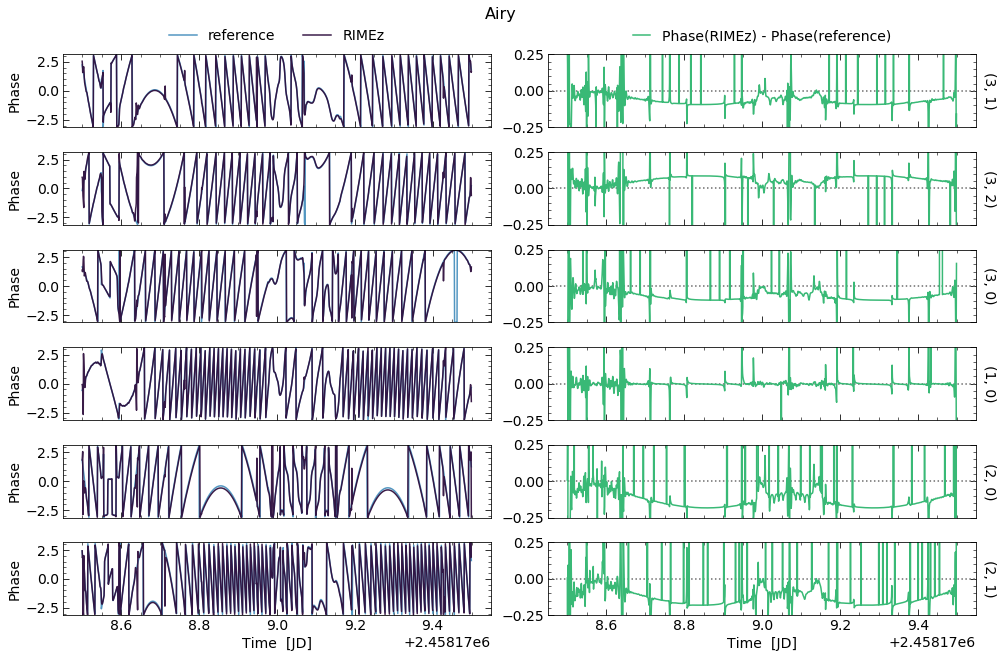

In [21]:
fig, ax = plt.subplots(len(bls_12)-1, 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['airy'], uvd_rimez_12['airy'], bls_12[1:], ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.suptitle('Airy', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 9** | The same as Figure 5 for an Airy beam.

### 1.2: HERA beam

#### Amplitude

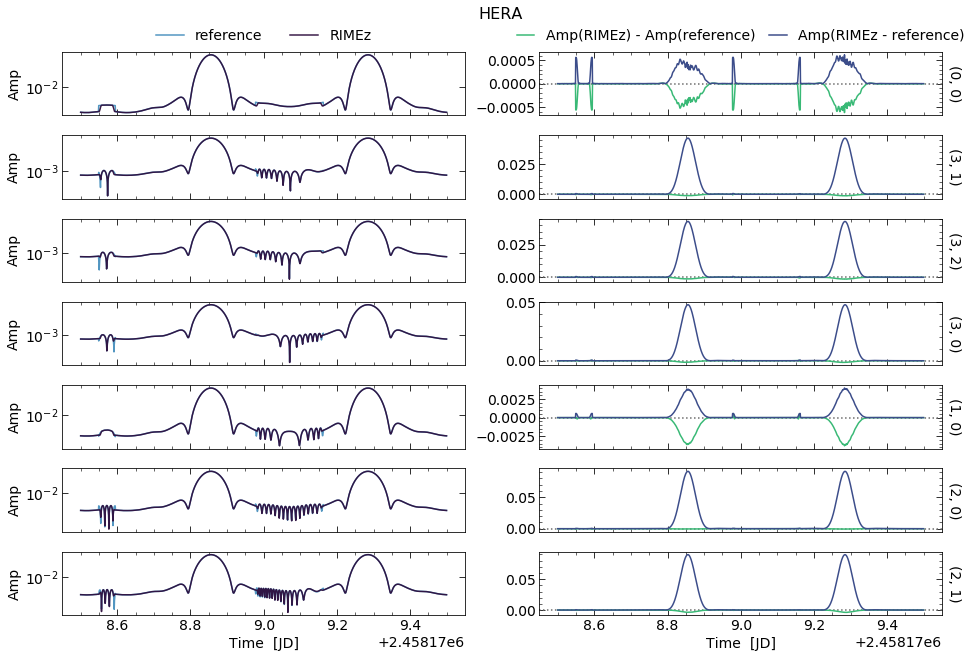

In [22]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['hera'], uvd_rimez_12['hera'], bls_12, ax=ax, component='amp')
for axis in ax[:, 0]:
    axis.set_yscale('log')
fig.suptitle('HERA', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 10** | The same as Figure 4 for the H1C HERA beam.

#### Phase

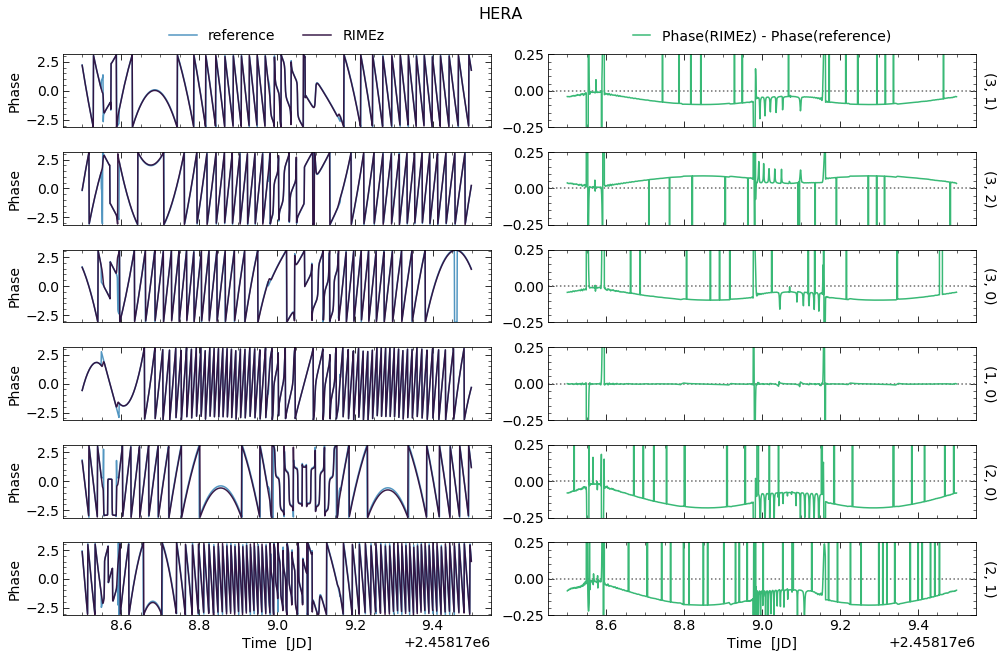

In [23]:
fig, ax = plt.subplots(len(bls_12)-1, 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['hera'], uvd_rimez_12['hera'], bls_12[1:], ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.suptitle('HERA', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 11** | The same as Figure 5 for the H1C HERA beam.

## Reference Simulation 1.3 (two times, 100-200 MHz)

Although the 1.3 reference simulations include the expanded frequency range of HERA H3C and beyond (50-250 MHz), we restrict ourselves to discussing the 100-200 MHz band of H1C and we emphasize that this validation of `RIMEz` holds _only_ for H1C validation tests. We also only show the first time in the simulations, as the trends with frequency do not change significantly between the two times.

In [24]:
uvd_ref_13 = {'uniform': UVData(),
              'gauss': UVData(),
              'airy': UVData(),
              'hera': UVData()}
uvd_ref_13['uniform'].read(ref_path_dict['1.3_uniform'], run_check_acceptability=False)
uvd_ref_13['gauss'].read(ref_path_dict['1.3_gauss'], run_check_acceptability=False)
uvd_ref_13['airy'].read(ref_path_dict['1.3_airy'], run_check_acceptability=False)
uvd_ref_13['hera'].read(ref_path_dict['1.3_uvbeam'], run_check_acceptability=False)

uvd_rimez_13 = {'uniform': UVData(),
                'gauss': UVData(),
                'airy': UVData(),
                'hera': UVData()}
uvd_rimez_13['uniform'].read(rimez_path_dict['1.3_uniform'], run_check_acceptability=False)
uvd_rimez_13['gauss'].read(rimez_path_dict['1.3_gauss'], run_check_acceptability=False)
uvd_rimez_13['airy'].read(rimez_path_dict['1.3_airy'], run_check_acceptability=False)
uvd_rimez_13['hera'].read(rimez_path_dict['1.3_uvbeam'], run_check_acceptability=False)

# conjugate the RIMEz data
for beam in uvd_rimez_13.keys():
    uvd_rimez_13[beam].conjugate_bls(convention='ant2<ant1')

bls_13 = get_sorted_baselines(uvd_rimez_13['uniform'])

Telescope BLLITE is not in known_telescopes.
Telescope RIMEz is not in known_telescopes.


### 1.3: Uniform beam

#### Amplitude

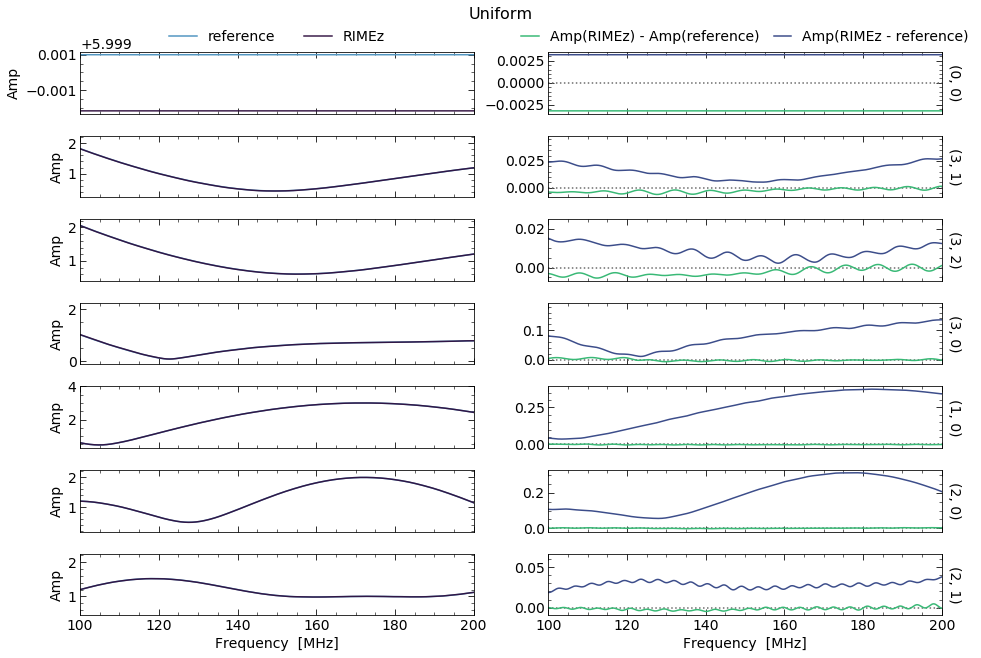

In [25]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['uniform'], uvd_rimez_13['uniform'], bls_13, ax=ax, component='amp')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[1:, 0]:
    axis.set_ylim(ymax=2.25)
ax[4, 0].set_ylim(ymax=4)
fig.suptitle('Uniform', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 12** | A comparison of the amplitudes as a function of frequency at one time of 12 point sources spelling out the letter "R" for a uniform beam from `RIMEz` and `pyuvsim`. Left: The visibilities from `pyuvsim` (light blue) and `RIMEz` (dark blue) overplotted on top of each other. Right: The difference of the amplitudes (green) and the amplitude of the difference (blue). The slow frequency drifting in the difference plots reflect the absolute amplitudes of the visiblities.

#### Phase

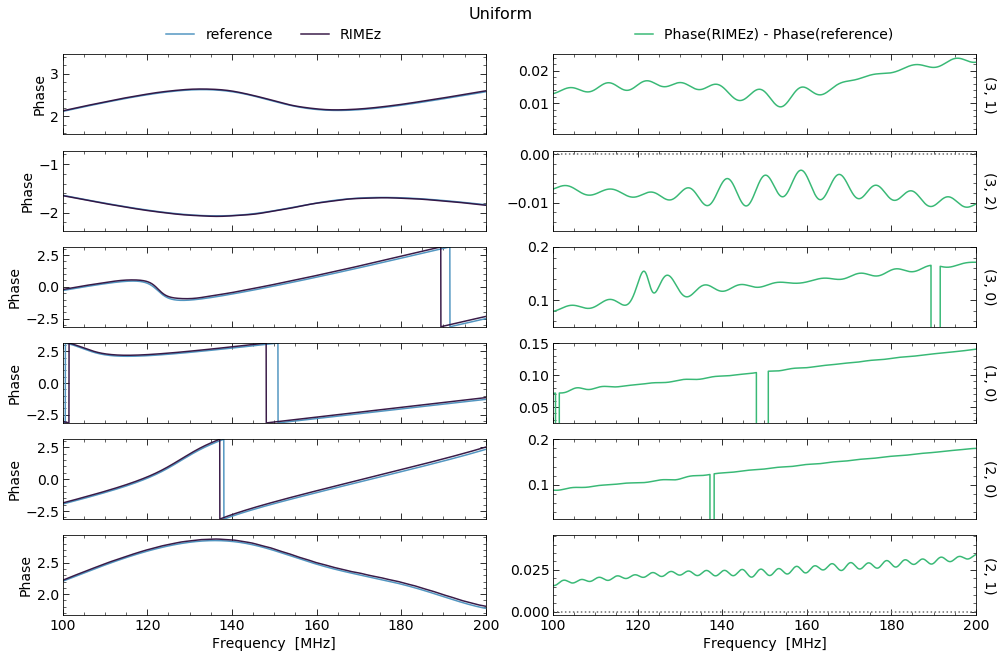

In [26]:
fig, ax = plt.subplots(len(bls_13)-1, 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['uniform'], uvd_rimez_13['uniform'], bls_13[1:], ax=ax, component='phase')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[2:5, 0]:
    axis.set_ylim([-np.pi, np.pi])
ax[0, 0].set_ylim(ymin=np.pi/2)
ax[0, 1].set_ylim([0.0005, 0.025])
ax[2, 1].set_ylim([0.05, 0.2])
ax[3, 1].set_ylim([0.025, 0.15])
ax[4, 1].set_ylim([0.025, 0.2])
fig.suptitle('Uniform', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 13** | A comparison of the phase as a function of frequency at one time of 12 point sources spelling out the letter "R" for a uniform beam from `RIMEz` and `pyuvsim`. Left: The visibilities from `pyuvsim` (light blue) and `RIMEz` (dark blue) overplotted on top of each other. Right: The difference of the phases. There is a systematic offset in the phases, where the `RIMEz` phases are larger than the `pyuvsim` phases. Additionally, the `RIMEz` phase drifts away from the `pyuvsim` for all baselines, but the drift is less significant for smaller north-south baseline components (see Figure 2), likely due to source position errors in `RIMEz`.

### 1.3: Gaussian beam

#### Amplitude

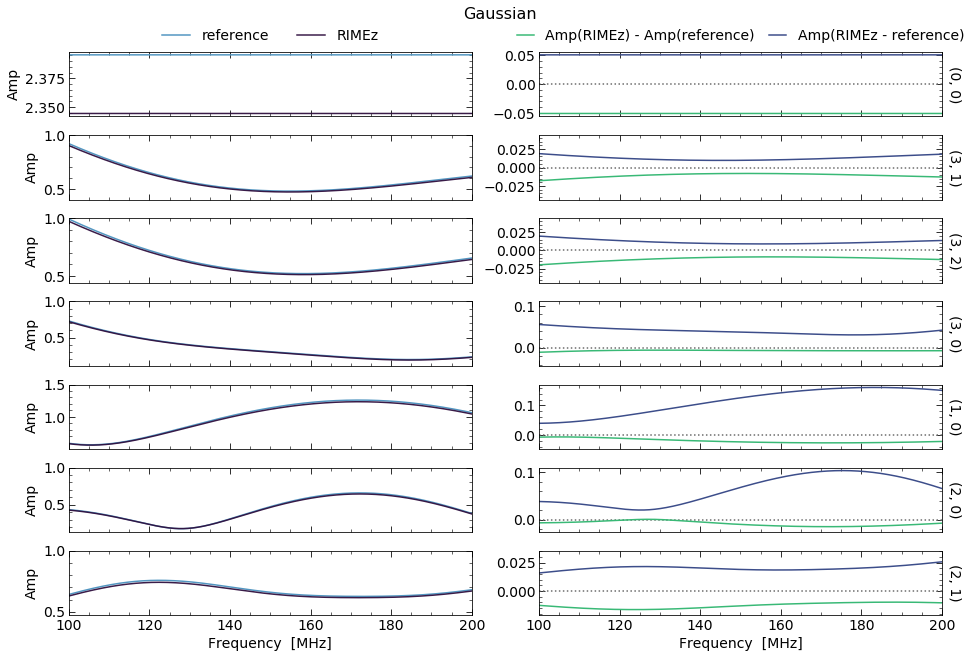

In [27]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['gauss'], uvd_rimez_13['gauss'], bls_13, ax=ax, component='amp')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[1:, 0]:
    axis.set_ylim(ymax=1)
ax[4, 0].set_ylim(ymax=1.5)
fig.suptitle('Gaussian', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 14** | The same as Figure 12 for a Gaussian beam. The fast oscillations in the differences from the uniform beam are damped out when using a Gaussian beam, likely because the horizon cutoff is smooth. Otherwise, the trends are the same as those in Figure 11 (see the caption).

#### Phase

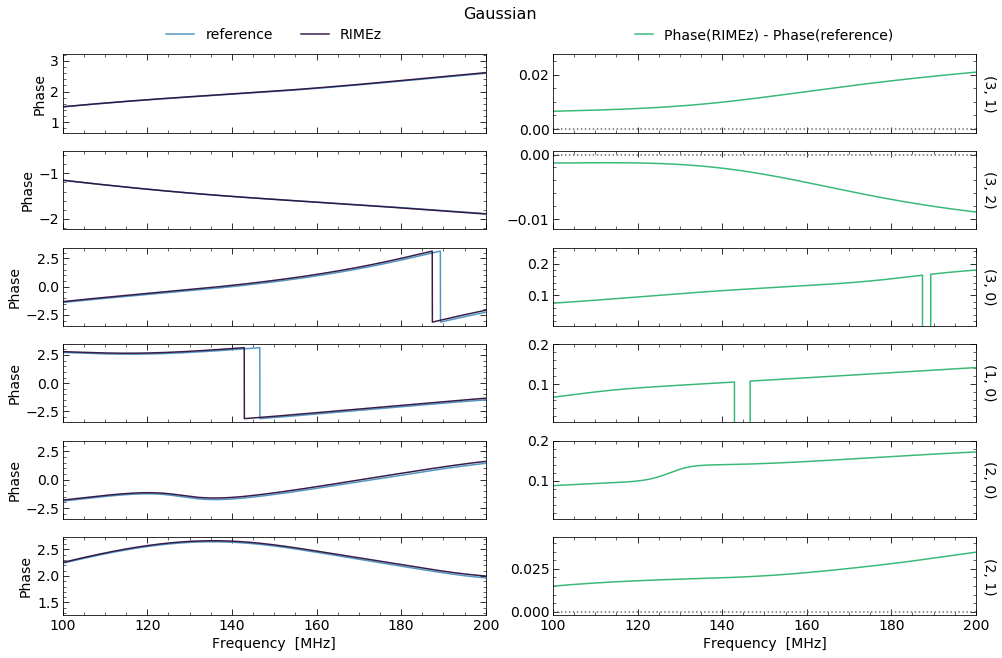

In [28]:
fig, ax = plt.subplots(len(bls_13)-1, 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['gauss'], uvd_rimez_13['gauss'], bls_13[1:], ax=ax, component='phase')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[2:5, 1]:
    axis.set_ylim([-np.pi, np.pi])
ax[2, 1].set_ylim([0.005, 0.25])
ax[3, 1].set_ylim([0.005, 0.2])
ax[4, 1].set_ylim([0.005, 0.2])
fig.suptitle('Gaussian', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 15** | The same as Figure 13 for a Gaussian beam. As in Figure 13, the fast oscillations from the horizon cutoff are damped out with a Gaussian beam.

### 1.3: Airy beam

#### Amplitude

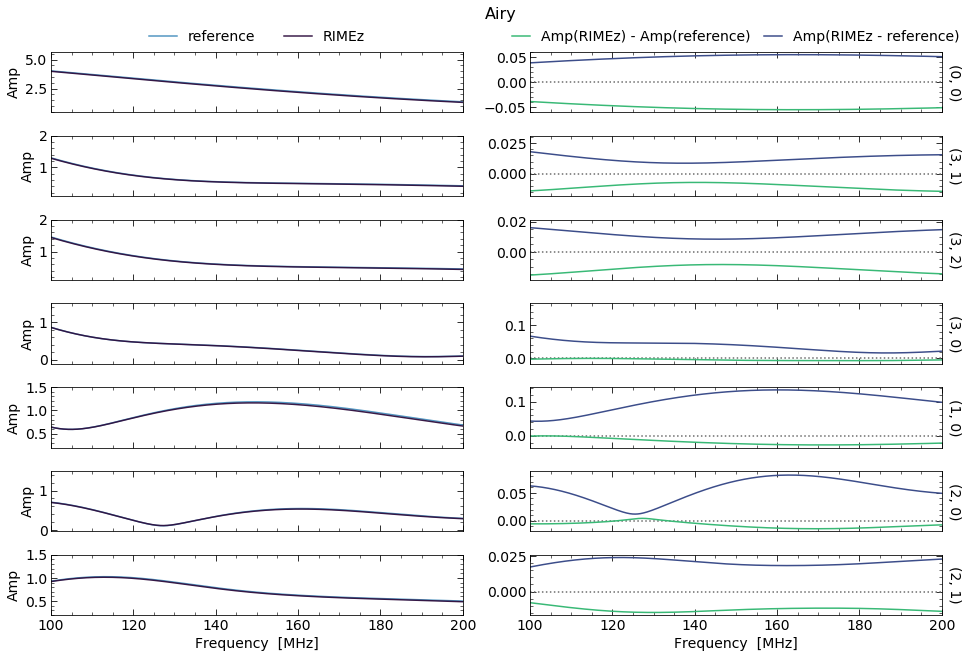

In [29]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['airy'], uvd_rimez_13['airy'], bls_13, ax=ax, component='amp')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[1:3, 0]:
    axis.set_ylim(ymax=2)
for axis in ax[3:, 0]:
    axis.set_ylim(ymax=1.5)
fig.suptitle('Airy', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 16** | The same as Figure 12 for an Airy beam.

#### Phase

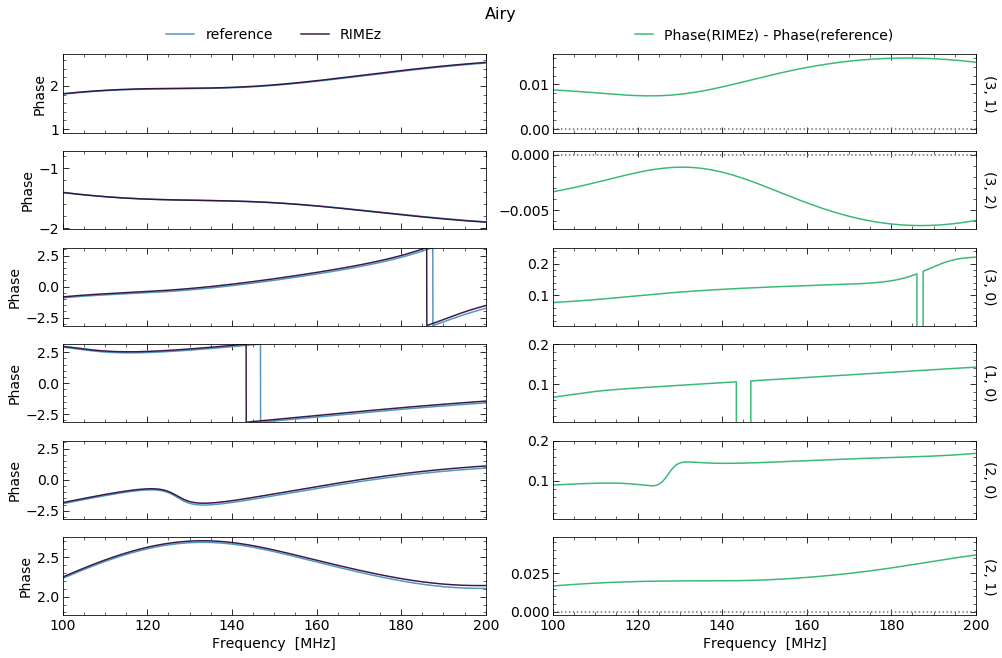

In [30]:
fig, ax = plt.subplots(len(bls_13)-1, 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['airy'], uvd_rimez_13['airy'], bls_13[1:], ax=ax, component='phase')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[2:5, 0]:
    axis.set_ylim([-np.pi, np.pi])
ax[2, 1].set_ylim([0.005, 0.25])
ax[3, 1].set_ylim([0.005, 0.2])
ax[4, 1].set_ylim([0.005, 0.2])
fig.suptitle('Airy', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 17** | The same as Figure 13 for an Airy beam.

### 1.3: HERA beam

#### Amplitude

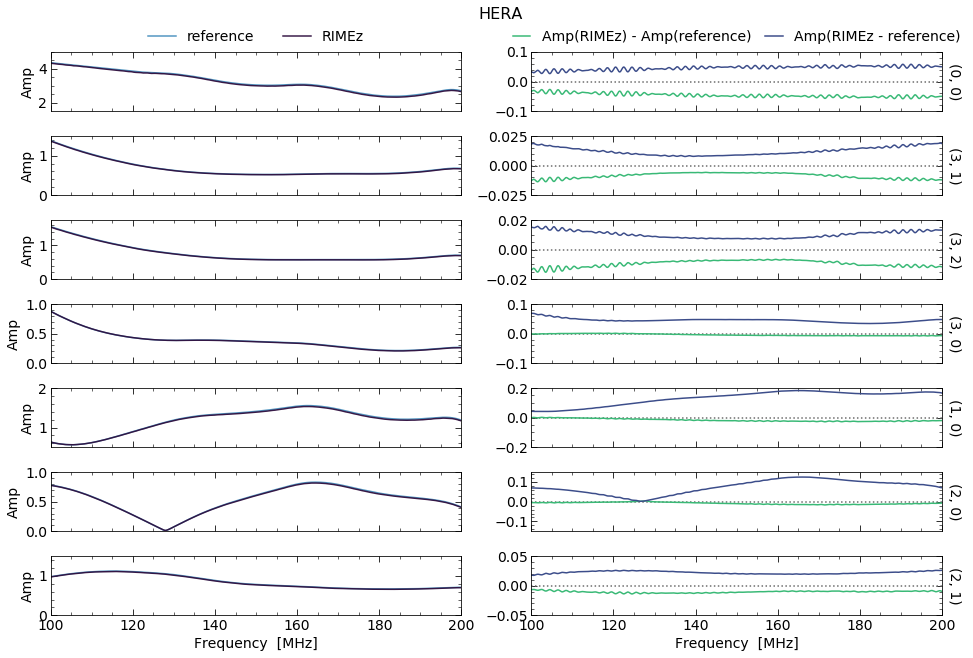

In [31]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['hera'], uvd_rimez_13['hera'], bls_13, ax=ax, component='amp')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[1:, 0]:
    axis.set_ylim(ymax=2)
ax[0, 0].set_ylim([1.5, 5])
ax[1, 0].set_ylim([0, 1.5])
ax[2, 0].set_ylim([0, 1.75])
ax[3, 0].set_ylim([0, 1])
ax[4, 0].set_ylim([0.5, 2])
ax[5, 0].set_ylim([0, 1])
ax[6, 0].set_ylim([0, 1.5])
ax[0, 1].set_ylim([-0.1, 0.1])
ax[1, 1].set_ylim([-0.025, 0.025])
ax[2, 1].set_ylim([-0.02, 0.02])
ax[3, 1].set_ylim([-0.1, 0.1])
ax[4, 1].set_ylim([-0.2, 0.2])
ax[5, 1].set_ylim([-0.15, 0.15])
ax[6, 1].set_ylim([-0.05, 0.05])
fig.suptitle('HERA', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 18** | The same as Figure 12 for the H1C HERA beam.

#### Phase

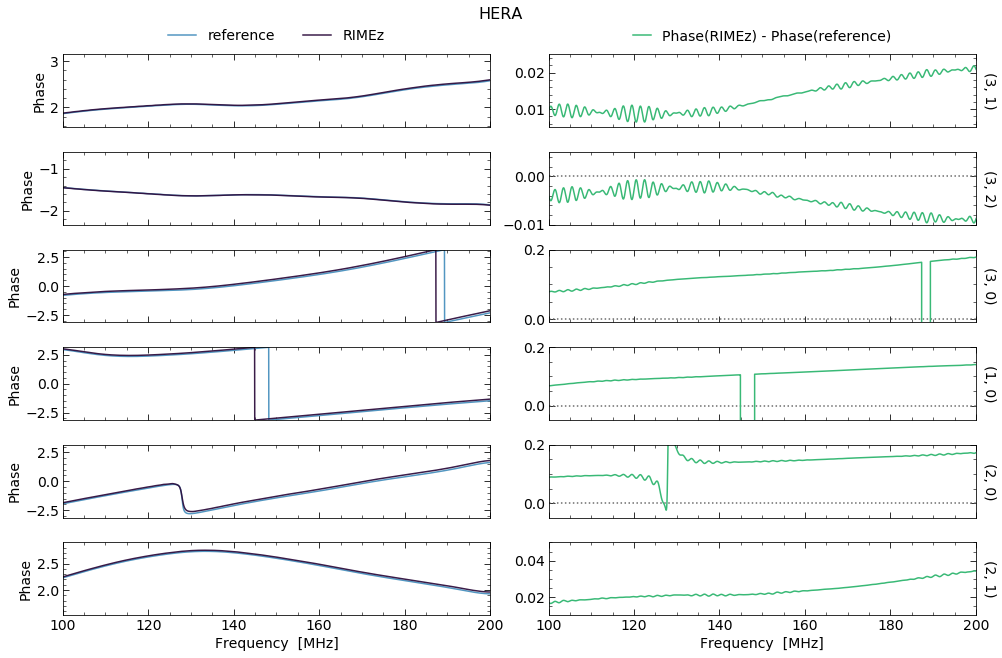

In [32]:
fig, ax = plt.subplots(len(bls_13)-1, 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['hera'], uvd_rimez_13['hera'], bls_13[1:], ax=ax, component='phase')
for axis in ax.flatten():
    axis.set_xlim([100, 200])
for axis in ax[2:5, 0]:
    axis.set_ylim([-np.pi, np.pi])
ax[0, 0].set_ylim([np.pi/2, np.pi])
ax[0, 1].set_ylim([0.005, 0.025])
ax[1, 1].set_ylim([-0.01, 0.005])
ax[2, 1].set_ylim([-0.01, 0.2])
ax[3, 1].set_ylim([-0.05, 0.2])
ax[4, 1].set_ylim([-0.05, 0.2])
ax[5, 1].set_ylim([0.01, 0.05])
fig.suptitle('HERA', fontsize=16, x=0.5, y=1.01)
fig.tight_layout()

**Figure 19** | The same as Figure 13 for the HERA beam.

## Source position errors in reference simulation 1.1

`pyuvsim` uses a `pyradiosky.SkyModel` object to calculate source positions while `RIMEz` uses a self-contained utility function. Additionally, `RIMEz` assumes that input coordinates have been pre-processed from ICRS to apparent CIRS coordinates at the time of observation.

In [33]:
# Load the catalog
catalog_path = ('/lustre/aoc/projects/hera/Validation/test-neg1.1.0/config_files/' +
                'catalog_files/mock_catalog_heratext_2458098.38824015.txt')
catalog = pyradiosky.read_text_catalog(catalog_path, return_table=True)
ra = np.array([catalog[i][1] for i in range(len(catalog))]) * u.deg
dec = np.array([catalog[i][2] for i in range(len(catalog))]) * u.deg
flux = np.array([catalog[i][3][0] for i in range(len(catalog))])
flux = np.expand_dims(flux, axis=0)  # RIMEz needs an array of shape (Nfreq=1, Nsrc)

In [34]:
# pyuvsim parameters
sources = pyradiosky.array_to_skymodel(catalog)
hera_lat = -30.72152777777791 * u.deg
hera_lon = 21.428305555555557 * u.deg
hera_height = 1073.0000000093132 * u.m
hera_location = EarthLocation(lat=hera_lat, lon=hera_lon, height=hera_height)
time_11 = Time(2458098.38824015, format='jd')  # Only one time in this simulation

In [35]:
# RIMEz parameters
array_layout_path = ('/lustre/aoc/projects/hera/Validation/test-neg1.1.0/config_files/' +
                     'telescope_config/mwa_nocore_downsampled_layout.csv')
ant_pos_meters = np.genfromtxt(array_layout_path, skip_header=1, usecols=(3, 4, 5))  # ENU
ant_pairs_used, u2a, a2u = utils.get_minimal_antenna_set(ant_pos_meters, precision=3)
ant_beam_function_map = np.zeros(ant_pos_meters.shape[0], dtype=np.int64)

# Uniform beam
beam_funcs = beam_models.uniform

# Cutoff for Fourier series
integral_kernel_cutoff = utils.kernel_cutoff_estimate(
                            np.amax(list(u2a.keys())),
                            1e8, # frequency in Hz
                            width_estimate=100)

# All parameters here come from the 1.1 config file
parameters = {
    'array_latitude': hera_lat.to(u.rad).value,
    'array_longitude': hera_lon.to(u.rad).value,
    'array_height': hera_height.value,
    'initial_time_sample_jd': time_11.value,
    'integration_time': 11.0,
    'frequency_samples_hz': np.array([1e8]),
    'antenna_positions_meters': ant_pos_meters,
    'antenna_pairs_used': ant_pairs_used,
    'antenna_beam_function_map': ant_beam_function_map,
    'integral_kernel_cutoff': integral_kernel_cutoff,
    'time_sample_jds': time_11.value
}

# Convert to CIRS for RIMEz
sources_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs')
sources_cirs = sources_icrs.transform_to(CIRS(obstime=time_11))
ra_cirs, dec_cirs = sources_cirs.ra.rad, sources_cirs.dec.rad

Slm = sky_models.point_sources_harmonics(flux, ra_cirs, dec_cirs, L=1)
Slm = Slm.reshape(Slm.shape + (1,))
VC = management.VisibilityCalculation(parameters, beam_funcs, Slm)

# Parameters for fast_approx_radec2altaz (copied from vec_mmode_unpol_visibilities in RIMEz)
R_0 = VC.R_0[0]  # some magic happens in numba to make this into a (3, 3) array

In [36]:
# pyuvsim and RIMEz alt/az
sources.update_positions(time_11, hera_location)
ref_alt, ref_az = sources.alt_az[0] * u.rad, sources.alt_az[1] * u.rad

_, rimez_alt, rimez_az = rime_funcs.fast_approx_radec2altaz(ra_cirs.flatten(), dec_cirs.flatten(), R_0.T)
rimez_alt, rimez_az = rimez_alt * u.rad, rimez_az * u.rad

# RIMEz - ref position differences
alt_difference = rimez_alt - ref_alt
az_difference = rimez_az - ref_az

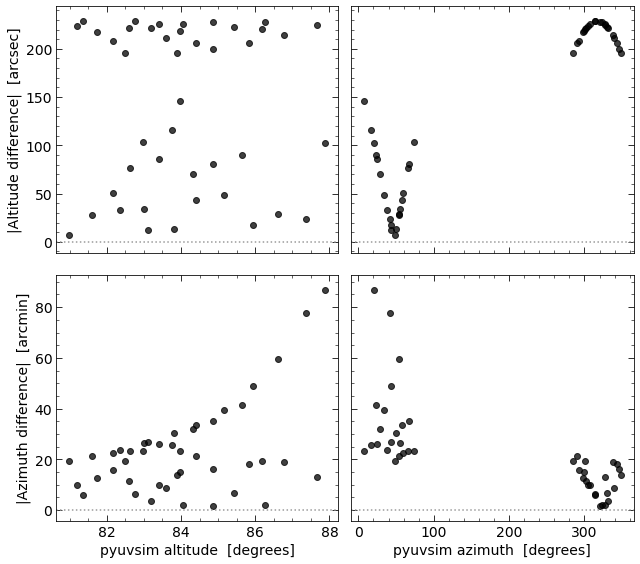

In [37]:
# One-dimensional plots of the differences to look at trends
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(9, 8))
for axis in ax.flatten():
    axis.axhline(0, ls=':', c='#999999')
ax[0, 0].scatter(ref_alt.to(u.deg).value, np.abs(alt_difference.to(u.arcsec).value),
                 c='k', alpha=0.75)
ax[1, 0].scatter(ref_alt.to(u.deg).value, np.abs(az_difference.to(u.arcmin).value),
                 c='k', alpha=0.75)
ax[0, 1].scatter(ref_az.to(u.deg).value, np.abs(alt_difference.to(u.arcsec).value),
                 c='k', alpha=0.75)
ax[1, 1].scatter(ref_az.to(u.deg).value, np.abs(az_difference.to(u.arcmin).value),
                 c='k', alpha=0.75)
ax[1, 0].set_xlabel('pyuvsim altitude  [degrees]', fontsize=14)
ax[1, 1].set_xlabel('pyuvsim azimuth  [degrees]', fontsize=14)
ax[0, 0].set_ylabel('|Altitude difference|  [arcsec]', fontsize=14)
ax[1, 0].set_ylabel('|Azimuth difference|  [arcmin]', fontsize=14)
fig.tight_layout()

**Figure 20** | Absolute value of the difference between the `RIMEz` and `pyuvsim` source positions as a function of source position from `pyuvsim`. Azimuth errors are on the order of arcminutes, which altitude errors are on the order of arcseconds. Both altitude and azimuth errors depend on both the true altitude and azimuth of the source.

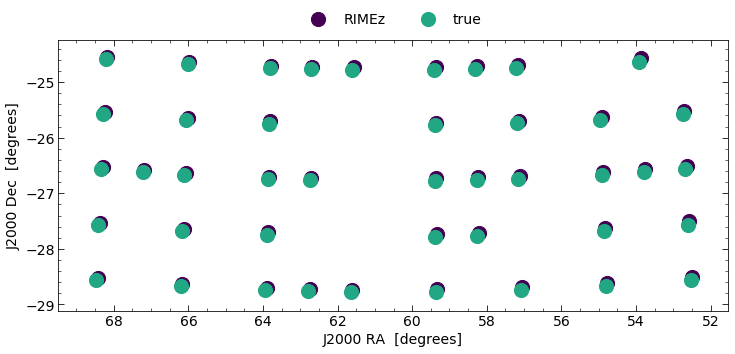

In [38]:
# Convert RIMEz alt/az back to RA/dec and look at the new positions
rimez_alt_az = AltAz(alt=rimez_alt, az=rimez_az, obstime=time_11, location=hera_location)
rimez_ra_dec = rimez_alt_az.transform_to(ICRS)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(rimez_ra_dec.ra, rimez_ra_dec.dec, c='#440154', marker='o', s=200, label='RIMEz')
ax.scatter(ra, dec, c='#22A784', marker='o', s=200, label='true')
ax.set_xlabel('J2000 RA  [degrees]', fontsize=14)
ax.set_ylabel('J2000 Dec  [degrees]', fontsize=14)
ax.invert_xaxis()
ax.legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.075));

**Figure 21** | A comparison of the source catalog positions and the positions calculated by `RIMEz`. 

## The effect of $\ell_\text{max}$

The maximum value of $\ell$, $\ell_\text{max}$, sets the spatial resolution of the simulation, which depends on the maximum baseline length in units of wavelength. The expression
$$\ell_\text{max} \approx \dfrac{2\pi\lvert\mathbf{u}\rvert_\text{max}}{c}$$
is a reasonable estimate for the value of $\ell_\text{max}$, although for these tests, we have added 100 to this approximation to be safe.

#### Long time axis

In [39]:
lmax180_time_path = os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax180.uvh5')
lmax500_time_path = os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax500.uvh5')
uvd_lmax_time = {'180': UVData(), '500': UVData()}
uvd_lmax_time['180'].read(lmax180_time_path, run_check_acceptability=False)
uvd_lmax_time['500'].read(lmax500_time_path, run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
for beam in uvd_lmax_time.keys():
    uvd_lmax_time[beam].conjugate_bls(convention='ant2<ant1')

Telescope RIMEz is not in known_telescopes.


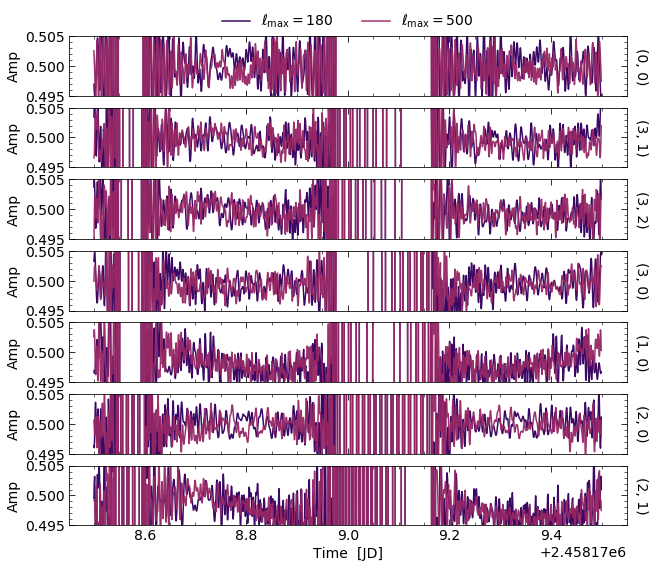

In [40]:
# overplot the amplitudes
fig, ax = plt.subplots(len(bls_12), 1, sharex='col', figsize=(10, 9))
for i, bl in enumerate(bls_12):
    ant1, ant2 = uvd_lmax_time['180'].baseline_to_antnums(bl)
    key = (ant1, ant2, 'ee')
    
    # overplot the visibilities
    times = np.unique(uvd_lmax_time['180'].time_array)
    lmax180_data = np.abs(uvd_lmax_time['180'].get_data(key))
    lmax500_data = np.abs(uvd_lmax_time['500'].get_data(key))
    ax[i].plot(times, lmax180_data, c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(times, lmax500_data, c='#972765', alpha=0.95, label=r'$\ell_\mathrm{max} = 500$')
    
    # formatting things
    ax[i].set_ylim([0.495, 0.505])
    ax[i].set_ylabel('Amp', fontsize=14)          
    ax[i].text(1.025, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
        
ax[-1].set_xlabel('Time  [JD]', fontsize=14)
ax[0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25));

**Figure 22** | A comparison of the amplitude as a function of time using a small ($\ell_\text{max} = 180$) and larger ($\ell_\text{max} = 500$) value of $\ell_\text{max}$ for a uniform beam.

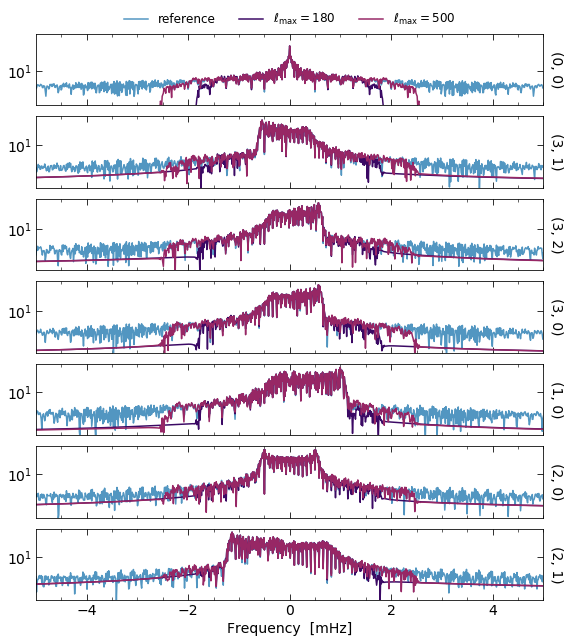

In [41]:
dt = TimeDelta(times[1] - times[0], format='jd').to_value('sec') / 1000  # kiloseconds
data_temp = uvd_lmax_time['180'].get_data(0, 0, 'ee')
xaxis = np.fft.fftshift(np.fft.fftfreq(len(data_temp), d=dt))  # mHz

fig, ax = plt.subplots(len(bls_12), 1, sharex='col', figsize=(8, 9))
for i, bl in enumerate(bls_12):
    ant1, ant2 = uvd_lmax_time['180'].baseline_to_antnums(bl)
    key_ref = (ant1, ant2, 'xx')
    key_rimez = (ant1, ant2, 'ee')
    data_ref = uvd_ref_12['uniform'].get_data(key_ref)
    data_lmax180 = uvd_lmax_time['180'].get_data(key_rimez)
    data_lmax500 = uvd_lmax_time['500'].get_data(key_rimez)
    ft_ref = np.fft.fftshift(np.fft.fft(data_ref, axis=0))
    ft_lmax180 = np.fft.fftshift(np.fft.fft(data_lmax180, axis=0))
    ft_lmax500 = np.fft.fftshift(np.fft.fft(data_lmax500, axis=0))
    ax[i].plot(xaxis, np.abs(ft_ref), c='#5296C1', label='reference')
    ax[i].plot(xaxis, np.abs(ft_lmax180), c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(xaxis, np.abs(ft_lmax500), c='#972765', label=r'$\ell_\mathrm{max} = 500$')
    ax[i].set_xlim(-5, 5)
    ax[i].set_yscale('log')
    ax[i].text(1.025, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
ax[-1].set_xlabel('Frequency  [mHz]', fontsize=14)
ax[0].legend(loc='center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2), fontsize=12)
ax[0].set_ylim(ymin=0.02)
for axis in ax[1:]:
    axis.set_ylim(ymin=0.05)
fig.tight_layout()

**Figure 23** | A comparison of the fringe rate spectrum for the two values of $\ell_\text{max} = 180, 500$ and the reference simulation. The larger value of $\ell_\text{max]$ does a better job of recovering the true result than the smaller value. The uniform beam includes a step function at horizon, which requires infinite Fourier modes to capture. Using more Fourier modes extends the fidelity to larger fringe rates. The effect of this in frequency/time is to induce oscillations.

#### Long frequency axis

In [42]:
lmax180_freq_path = os.path.join(rimez_path, 'rimez_1.3_uniform_lmax180.uvh5')
lmax500_freq_path = os.path.join(rimez_path, 'rimez_1.3_uniform_lmax500.uvh5')
uvd_lmax_freq = {'180': UVData(), '500': UVData()}
uvd_lmax_freq['180'].read(lmax180_freq_path, run_check_acceptability=False)
uvd_lmax_freq['500'].read(lmax500_freq_path, run_check_acceptability=False)

# conjugate the RIMEz data
for beam in uvd_lmax_freq.keys():
    uvd_lmax_freq[beam].conjugate_bls(convention='ant2<ant1')

Telescope RIMEz is not in known_telescopes.


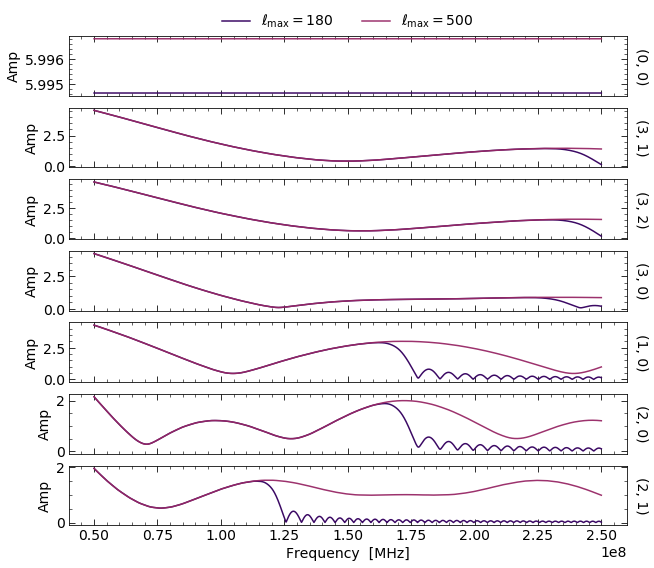

In [43]:
# overplot the amplitudes
fig, ax = plt.subplots(len(bls_13), 1, sharex='col', figsize=(10, 9))
for i, bl in enumerate(bls_13):
    ant1, ant2 = uvd_lmax_freq['180'].baseline_to_antnums(bl)
    key = (ant1, ant2, 'ee')

    # overplot the visibilities
    freqs = np.unique(uvd_lmax_freq['180'].freq_array)
    lmax180_data = np.abs(uvd_lmax_freq['180'].get_data(key))
    lmax500_data = np.abs(uvd_lmax_freq['500'].get_data(key))
    ax[i].plot(freqs, lmax180_data[0], c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(freqs, lmax500_data[0], c='#972765', alpha=0.95, label=r'$\ell_\mathrm{max} = 500$')
    
    # formatting things
    ax[i].set_ylabel('Amp', fontsize=14)          
    ax[i].text(1.025, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
        
ax[-1].set_xlabel('Frequency  [MHz]', fontsize=14)
ax[0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25));

**Figure 24** | A comparison of the amplitude as a function of frequency using small and larger values of $\ell_\text{max}$ ($\ell_\text{max} = 180$ and $\ell_\text{max} = 500$, respectively) for a uniform beam. The small value of $\ell_\text{max}$, which is less than the estimated "optimal" value of $\ell_\text{max} \approx 472$, results in a cutoff in frequency at which the sources are not adequately resolved.